## Detect Medicare Fraud at a Physician Level

- Combining all years for CMS (2012-2017) and LEIE (01/2018-12/2019).

- Follow directions from Johnson & Khoshgoftaar (2019) to clean both sets.

- Classify each row as fraudulent (1) or not (0) based on exclusion dates.

(COS API did not work great, so all files were written in from local then uploaded to COS.)

### Menu

- <a href='#cms'>1. Get CMS Data</a>

- <a href='#leie'>2. Get LEIE Data</a>

- <a href='#combined'>3. Combine and Label Fraud</a>

- <a href='#visualization'>4. Build Visualizations</a>
    - <a href='#visualization'>Chart A</a>

- <a href='#train'>5. Clean Data for Training</a>

In [1]:
import os
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

In [2]:
# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share the notebook.
# client_2c96a895be1c4c6fbdb974fb06084271 = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='rixfgKn8meWFMo9bgKuWqszB1oKlUhKx-t1WnKbo-saT',
#     ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud')

# def __iter__(self): return 0
# body = client_2c96a895be1c4c6fbdb974fb06084271.get_object(Bucket='healthlock-ai-data-cos',Key=f'CMSData/cms2012.txt')['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# df = pd.read_csv(body, delimiter='\t')

In [3]:
# Set up data directory
CWD = os.getcwd()
cms_data_dir = os.path.join(CWD, 'CMSData')

In [4]:
# Some years columns are capitalized and other years the columns are lowercase:
capitalization_dict = {
    '2012': str.upper,
    '2013': str.upper,
    '2014': str.lower,
    '2015': str.lower,
    '2016': str.upper,
    '2017': str.lower,
}

<a id='cms'></a>

### 1. CMS Part B dataset

In [5]:
# Set dtypes based on https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/...
#Medicare-Provider-Charge-Data/Physician-and-Other-Supplier2017
partB_dtypes = {
    'npi': 'int64',
    'nppes_provider_last_org_name': 'str',
    'nppes_provider_first_name': 'str',
    'nppes_provider_mi': 'str',
    'nppes_credentials': 'str',
    'nppes_provider_gender': 'str',
    'nppes_entity_code': 'str',
    'nppes_provider_street1': 'str',
    'nppes_provider_street2': 'str',
    'nppes_provider_city': 'str',
    'nppes_provider_zip': 'str',
    'nppes_provider_state': 'str',
    'nppes_provider_country': 'str',
    'provider_type': 'str',
    'medicare_participation_indicator': 'str',
    'place_of_service': 'str',
    'hcpcs_code': 'str',
    'hcpcs_description': 'str',
    'hcpcs_drug_indicator': 'str',
    'line_srvc_cnt': 'float64',
    'bene_unique_cnt': 'float64',    
    'bene_day_srvc_cnt': 'float64',
    'average_medicare_allowed_amt': 'float64',
    'average_submitted_chrg_amt': 'float64',
    'average_medicare_payment_amt': 'float64',
    'average_medicare_standard_amt': 'float64',
}

In [6]:
# Get dfs for all years - TAKE A FEW MINUTES
years = ['2012','2013','2014','2015','2016','2017']
dfs   = []

for year in years:
    file = os.path.join(cms_data_dir, f'cms{year}.txt')
    dtypes = dict(zip(list(map(capitalization_dict[year], partB_dtypes.keys())), list(partB_dtypes.values()))) #get correct column capitalization and dtype
    df = pd.read_csv(file, delimiter='\t', dtype=dtypes)
    df.columns = map(str.lower, df.columns)  # make all variable names lowercase
    df['year'] = year #add Year column 
    dfs.append(df)

In [7]:
# Concatenate
partB_df = pd.concat(dfs, axis=0, ignore_index=True, sort=False)
partB_df.shape

(39729303, 86)

In [8]:
# Drop missing NPI and HCPCS - "Medicare fraud detection using neural networks" (Johnson, Khoshgoftaar 2019)
partB_df = partB_df.dropna(subset = ['npi','hcpcs_code'])
partB_df.shape

(37653935, 86)

In [9]:
# Remove rows corresponding to drugs because LINE_SRVC_CNT for them is not a desirable count
partB_df = partB_df[(partB_df['hcpcs_drug_indicator'] == 'N')]
partB_df.shape

(35368294, 86)

In [10]:
# Keep variables based on "Medicare fraud detection using neural networks" (Johnson, Khoshgoftaar 2019)
partB_variables_to_keep = [
    'npi',
    'provider_type',
    'nppes_provider_city', # keep
    'nppes_provider_zip', # keep
    'nppes_provider_state', # keep
    'nppes_provider_country', # keep
    'hcpcs_code',  # not in paper but kept
    'hcpcs_description',  # not in paper but kept
    'hcpcs_drug_indicator',  # not in paper but kept
    'place_of_service',  # not in paper but kept
    'nppes_provider_gender',
    'line_srvc_cnt',
    'bene_unique_cnt',
    'bene_day_srvc_cnt',
    'average_submitted_chrg_amt',
    'average_medicare_payment_amt',
    'year' # need Year for labeling
]
partB_df = partB_df[partB_variables_to_keep]

In [11]:
partB_df.head()

,npi,provider_type,nppes_provider_city,nppes_provider_zip,nppes_provider_state,nppes_provider_country,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,place_of_service,nppes_provider_gender,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_submitted_chrg_amt,average_medicare_payment_amt,year
1,1003000126,Internal Medicine,CUMBERLAND,215021854,MD,US,99222,"Initial hospital inpatient care, typically 50 ...",N,F,M,115.0,112.0,115.0,199.0,108.115652,2012
2,1003000126,Internal Medicine,CUMBERLAND,215021854,MD,US,99223,"Initial hospital inpatient care, typically 70 ...",N,F,M,93.0,88.0,93.0,291.0,158.870000,2012
3,1003000126,Internal Medicine,CUMBERLAND,215021854,MD,US,99231,"Subsequent hospital inpatient care, typically ...",N,F,M,111.0,83.0,111.0,58.0,30.720721,2012
4,1003000126,Internal Medicine,CUMBERLAND,215021854,MD,US,99232,"Subsequent hospital inpatient care, typically ...",N,F,M,544.0,295.0,544.0,105.0,56.655662,2012
5,1003000126,Internal Medicine,CUMBERLAND,215021854,MD,US,99233,"Subsequent hospital inpatient care, typically ...",N,F,M,75.0,55.0,75.0,150.0,81.390000,2012


In [12]:
partB_df.loc[partB_df['npi'] == 1003000142][['npi',
                                             'provider_type',
                                             'place_of_service',
                                             'line_srvc_cnt',
                                             'average_submitted_chrg_amt',
                                             'year']][:5]

,npi,provider_type,place_of_service,line_srvc_cnt,average_submitted_chrg_amt,year
16,1003000142,Anesthesiology,O,28.0,216.571429,2012
17,1003000142,Anesthesiology,O,24.0,111.000000,2012
9153288,1003000142,Anesthesiology,F,56.0,483.000000,2013
9153289,1003000142,Anesthesiology,F,16.0,1105.000000,2013
9153290,1003000142,Anesthesiology,F,22.0,709.136364,2013


In [13]:
partB_df['year'].value_counts()

2016    9104337
2015    8904316
2013    8732934
2012    8626707
Name: year, dtype: int64

In [14]:
# Write all combined CMS to csv
#partB_df.to_csv('combined-partB-data-v2')

<a id='leie'></a>

### 2. LEIE Dataset

In [15]:
leie_data_dir = os.path.join(CWD, 'LEIEData')

In [16]:
leie_dtypes = {
    'LASTNAME': 'str',
    'FIRSTNAME': 'str',
    'MIDNAME': 'str',
    'BUSNAME' : 'str',
    'GENERAL': 'str',
    'SPECIALTY': 'str',
    'UPIN': 'str',
    'NPI': 'int64',
    'DOB': 'str',
    'ADDRESS': 'str',
    'CITY': 'str',
    'STATE': 'str',
    'ZIP': 'str',
    'EXCLTYPE': 'str',
    'EXCLDATE': 'int64',
    'REINDATE': 'int64',
    'WAIVERDATE': 'int64',
    'WVRSTATE': 'str',
}

In [17]:
#LEIE data is monthly between 01/2018 (1801) - 12/2019 (1912)
year_months = ['1801','1802','1803','1804','1805','1806','1807','1808','1809','1810','1811','1812',
            '1901','1902','1903','1904','1905','1906','1907','1908','1909','1910','1911','1912']
dfs = []

for year_month in year_months:
    file = os.path.join(leie_data_dir, f'leie{year_month}-excl.csv')
    df   = pd.read_csv(file, dtype=leie_dtypes)
    df.columns = map(str.lower, df.columns)
    dfs.append(df)

In [18]:
# Concatenate
leie_df = pd.concat(dfs, axis=0, ignore_index=True, sort=False)
leie_df.shape

(4983, 18)

In [19]:
leie_df.head()

,lastname,firstname,midname,busname,general,specialty,upin,npi,dob,address,city,state,zip,excltype,excldate,reindate,waiverdate,wvrstate
0,NaN,NaN,,CHANGING STEPS TREATMENT CENTE,OTHER BUSINESS,COMMUNITY HLTH CTR (,NaN,1477704351,NaN,"14540 HAMLIN ST, STE B",VAN NUYS,CA,91411,1128a1,20180220,0,0,NaN
1,NaN,NaN,,OLIVE TREE FOSTER HOME,OTHER BUSINESS,ADULT HOME,NaN,0,NaN,94-245 PUPUKOAE STREET,HONOLULU,HI,96797,1128a1,20180220,0,0,NaN
2,AIRHART,LAURA,PAULINE,NaN,IND- LIC HC SERV PRO,NURSE/NURSES AIDE,NaN,0,19770704,7304 FULLER CIRCLE,FORT WORTH,TX,76133,1128b4,20180220,0,0,NaN
3,ALBERT,AMY,,NaN,IND- LIC HC SERV PRO,PHYSICIAN'S ASSISTAN,NaN,1679639397,19770818,1124 GAINSBORO ROAD,LOWER MERION,PA,19004,1128b4,20180220,0,0,NaN
4,ALLEN,HEATHER,ANITRA,NaN,IND- LIC HC SERV PRO,NURSE/NURSES AIDE,NaN,0,19740326,1004 BINGHAM AVE,ROWAN,IA,50470,1128a3,20180220,0,0,NaN


In [20]:
# Drop NPI = 0, which means missing - A LOT ARE MISSING, which is a problem for the data
leie_df = leie_df[leie_df['npi'] != 0]
leie_df.shape

(1009, 18)

In [21]:
# Keep exclusions most related to Fraud
exclusions_to_keep = [
    '1128a1',
    '1128a2',
    '1128a3',
    '1128b4',
    '1128b7',
    '1128c3Gi',
    '1128c3gii',
]
leie_df = leie_df[leie_df['excltype'].isin(exclusions_to_keep)]
leie_df.shape

(669, 18)

In [22]:
leie_df['excltype'].value_counts()

1128a1    362
1128b4    154
1128a3     77
1128a2     44
1128b7     32
Name: excltype, dtype: int64

In [23]:
# Write all combined LEIE to csv
#partB_df.to_csv('combined-leie-data')

<a id='combined'></a>

### 3. Combine/Label Data

In [24]:
from datetime import datetime, timedelta
import numpy as np

In [25]:
# Convert to datetime
leie_df['excldate'] = pd.to_datetime(leie_df['excldate'], format='%Y%m%d', errors ='ignore')

In [26]:
# Round excl date to the nearest year Johnson & Khoshgoftaar (2019)
def round_to_year(dt=None):
    year = dt.year
    month = dt.month
    if month >= 6:
        year = year + 1
    return datetime(year=year,month=1,day=1)

leie_df['excl_year'] = leie_df.excldate.apply(lambda x: round_to_year(x))

In [27]:
# Make exclusion dict 
# 1215053665 has 2 exclusions, so sort df to get latest year
excl_year_dict = dict([npi, year] for npi, year in zip(leie_df.sort_values(by='excl_year').npi, leie_df.sort_values(by='excl_year').excl_year))

In [28]:
# Get label as 0 or 1
partB_df['excl_year'] = partB_df['npi'].map(excl_year_dict)
partB_df['excl_year'] = partB_df['excl_year'].fillna(datetime(year=1900,month=1,day=1)) # fill NaN, physicians without exclusion, with year 1900

partB_df['year'] = pd.to_datetime(partB_df['year'].astype(str), format='%Y', errors ='ignore')
partB_df['fraudulent'] = np.where(partB_df['year'] < partB_df['excl_year'], 1, 0) # compare year vs. exclusion year to get Fraudulent

In [125]:
print("partB_df is our combined dataset with shape: {0}".format(partB_df.shape))

partB_df is our combined dataset with shape: (35368294, 22)


<a id='visualization'></a>

### 4. Draw Visualizations

In [111]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [65]:
# Get number and amount of fraudulent services
partB_df['fraud_line_srvc_cnt'] = partB_df['line_srvc_cnt']*partB_df['fraudulent']
partB_df['fraud_average_submitted_chrg_amt'] = partB_df['average_submitted_chrg_amt']*partB_df['fraudulent']
partB_df['fraud_average_medicare_payment_amt'] = partB_df['average_medicare_payment_amt']*partB_df['fraudulent']

In [31]:
# Aggregate by state
state_df = partB_df.groupby('nppes_provider_state').agg({
    'line_srvc_cnt':[('total_services_count','sum')],
    'fraud_line_srvc_cnt':[('total_fraud_services_count','sum')]
}).reset_index()

# Drop multi-index
state_df.columns = ['_'.join(col) for col in state_df.columns]
state_df.columns = ['provider_state', 'total_services_count', 'fraud_services_count']

In [32]:
# Get % fraud
state_df['fraud_services_pct'] = state_df['fraud_services_count']/state_df['total_services_count']
state_df.head()

,provider_state,total_services_count,fraud_services_count,fraud_services_pct
0,AA,26875.0,0.0,0.000000
1,AE,45118.0,0.0,0.000000
2,AK,7096804.1,0.0,0.000000
3,AL,145179172.2,27972.0,0.000193
4,AP,35607.0,0.0,0.000000


In [40]:
np.seterr(divide = 'ignore') 

fig = go.Figure(data=go.Choropleth(
    locations=state_df['provider_state'],
    z = np.log(state_df['fraud_services_pct'].astype(float))+0.000001, #log-scale
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Logged %",
    marker_line_color='white'
))

fig.update_layout(
    title_text = 'Logged Percentage of Medicare Fraudulent Service by US State (2012-2016)',
    geo_scope='usa',
)

fig.show()

In [66]:
# Get dummy variables for gender
partB_df2 = pd.concat([partB_df, pd.get_dummies(partB_df['nppes_provider_gender'])], axis=1)

In [117]:
# Aggregate by provider type
type_df = partB_df2.groupby('provider_type').agg({
    'line_srvc_cnt':['sum'],
    'fraud_line_srvc_cnt':['sum'],
    'M':['sum'],
    'F':['sum'],
    'average_submitted_chrg_amt':['median'], #since distribution skewed right
    'average_medicare_payment_amt':['median'],
    'fraud_average_submitted_chrg_amt':['max'],
    'fraud_average_medicare_payment_amt':['max']
}).reset_index()

# Drop multi-index
type_df.columns = ['_'.join(col) for col in type_df.columns]
type_df.columns = ['provider_type', 'total_services_count', 'fraud_services_count','male_count','female_count',
                   'avg_submitted_chrg_amt','avg_medicare_payment_amt', 'fraud_avg_submitted_chrg_amt','fraud_avg_medicare_payment_amt']

In [118]:
# Sorting
type_df = type_df.sort_values('fraud_services_count',ascending=False)[:15] #get top 15 fraudulent types
type_df = type_df.sort_values('total_services_count',ascending=True).reset_index(drop=True) #re-sort by total services

# Add some fields
type_df['non_fraud_services_count'] = type_df['total_services_count'] - type_df['fraud_services_count']
type_df['fraud_services_pct'] = (type_df['fraud_services_count']/type_df['total_services_count'])*100
type_df.head()

,provider_type,total_services_count,fraud_services_count,male_count,female_count,avg_submitted_chrg_amt,avg_medicare_payment_amt,fraud_avg_submitted_chrg_amt,fraud_avg_medicare_payment_amt,non_fraud_services_count,fraud_services_pct
0,Geriatric Medicine,10738563.3,52334.0,42616.0,34393.0,155.594615,62.206552,800.000000,178.185878,10686229.3,0.487346
1,Pain Management,14888967.2,96178.0,90837.0,11511.0,300.000000,68.560030,1980.000000,288.390714,14792789.2,0.645968
2,General Practice,26465791.9,114533.0,150038.0,33452.0,94.000000,41.020000,603.641975,201.138500,26351258.9,0.432759
3,Anesthesiology,44806223.5,189943.0,733834.0,155457.0,718.158333,85.868923,2722.142857,547.420385,44616280.5,0.423921
4,Neurology,54613299.3,108023.0,398365.0,126310.0,221.935065,77.823478,2634.000000,604.060909,54505276.3,0.197796


KeyboardInterrupt: 

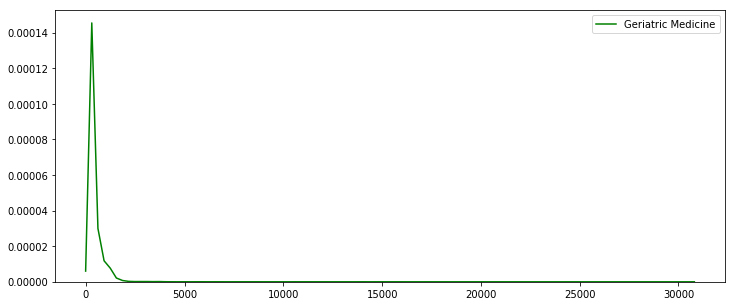

In [130]:
top_fifteen_types = type_df['provider_type'].tolist()

fig,ax = plt.subplots(figsize=(12,5))

for p_type in top_fifteen_types:
    sns.distplot(partB_df['average_medicare_payment_amt'], color='green',label=p_type, hist=False, rug=True)

ax.set(title='Average Medicare Payment for Top 15 Provider Types')
ax.legend()
plt.show()

In [120]:
fig = go.Figure()

col_layout_dict = {'non_fraud_services_count': ['Non-fraud Service Count','rgba(50, 171, 96, 0.6)'],
                 'fraud_services_count': ['Fraud Service Count','rgb(255, 0, 0)']} #dict for layout

for col in ['non_fraud_services_count','fraud_services_count']:
    fig.add_trace(go.Bar(
        y=type_df['provider_type'],
        x=type_df[col],
        name=col_layout_dict[col][0],
        marker=dict(
            color=col_layout_dict[col][1],
        ),
        orientation='h',
    ))

fig.update_layout(
    barmode = 'stack',
    title = 'Top 15 Fraudulent Medicare Category by Service Count',
    paper_bgcolor='white',
    plot_bgcolor='white',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.90],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.90],
    ),
)

annotations = [] #annotate with %

x   = type_df['fraud_services_count']+type_df['non_fraud_services_count']+100000000
y_p = np.round(type_df['fraud_services_pct'].tolist(), decimals=2)

for y_p, x, y in zip(y_p,x,type_df['provider_type']):
    annotations.append(dict(xref='x1', yref='y1',
                            y=y, x=x,
                            text=str(y_p) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(255, 0, 0)'),
                            showarrow=False))

annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        text='Combined CMS and LEIE data' +
                             'to label the leading Fraudulent physician categories (15 Feb 2020)',
                        font=dict(family='Arial', size=10, color='rgb(150,150,150)'),
                        showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

In [121]:
fig = go.Figure()

#dict for layout
col_layout_dict = {'female_count': ['Female Physicians ','#ffcdd2'],
                 'male_count': ['Male Physicians','#A2D5F2']}

for col in ['female_count','male_count']:
    fig.add_trace(go.Bar(
        y=type_df['provider_type'],
        x=type_df[col],
        name=col_layout_dict[col][0],
        marker=dict(
            color=col_layout_dict[col][1],
        ),
        orientation='h',
    ))

fig.update_layout(
    barmode = 'stack',
    title = 'Top 15 Fraudulent Medicare Category by Service Count and Gender',
    paper_bgcolor='white',
    plot_bgcolor='white',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.90],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.90],
    ),
)

fig.show()

Clinical Laboratory and Ambulance Service Provider has a lot of line services but require fewer doctors?

<a id='train'></a>

### 5. Prep Data for Training

- Aggregate data following paper's method
- Normalize predictors
- One hot encoding
- Write data for training (excluding state, city, zip)

In [ ]:
new_variables_to_keep = [
    'year',
    'npi',
    'provider_type',
    'nppes_provider_city',   #only keep for visualization
    'nppes_provider_state',  #only keep for visualization
    'nppes_provider_country',#only keep for visualization
    'nppes_provider_gender',
    'line_srvc_cnt',
    'bene_unique_cnt',
    'bene_day_srvc_cnt',
    'average_submitted_chrg_amt',
    'average_medicare_payment_amt',
    'fraudulent'
]

In [ ]:
#group by
temp_df = partB_df[new_variables_to_keep]

#agg by npi - provider_type and get sum stats
agg_partB_df = temp_df.groupby(by=['year','npi','provider_type','nppes_provider_city',
                      'nppes_provider_state','nppes_provider_country','nppes_provider_gender']).agg(
                    {
                    'line_srvc_cnt':["mean","median","std", min,max,sum],
                    'bene_unique_cnt':["mean","median","std", min,max,sum],
                    'bene_day_srvc_cnt':["mean","median","std", min,max,sum],
                    'average_submitted_chrg_amt':["mean","median","std", min,max,sum],
                    'average_medicare_payment_amt':["mean","median","std", min,max,sum],
                    'fraudulent':["mean"],
                    }).reset_index()

agg_partB_df.columns = ["_".join(x) for x in agg_partB_df.columns.ravel()] #unravel to get rid of multi-index column names

In [97]:
agg_partB_df.head()

,year_,npi_,provider_type_,nppes_provider_city_,nppes_provider_state_,nppes_provider_country_,nppes_provider_gender_,line_srvc_cnt_mean,line_srvc_cnt_median,line_srvc_cnt_std,...,average_submitted_chrg_amt_min,average_submitted_chrg_amt_max,average_submitted_chrg_amt_sum,average_medicare_payment_amt_mean,average_medicare_payment_amt_median,average_medicare_payment_amt_std,average_medicare_payment_amt_min,average_medicare_payment_amt_max,average_medicare_payment_amt_sum,fraudulent_mean
0,2012-01-01,1003000126,Internal Medicine,CUMBERLAND,MD,US,M,174.857143,111.0,166.951518,...,58.000000,291.000000,1060.000000,82.218697,81.390000,41.942570,30.720721,158.870000,575.530877,0
1,2012-01-01,1003000134,Pathology,EVANSTON,IL,US,M,959.125000,223.0,2076.546889,...,39.000000,263.000000,1065.000000,26.053306,25.187934,18.836154,7.815385,64.015735,208.426446,0
2,2012-01-01,1003000142,Anesthesiology,TOLEDO,OH,US,M,26.000000,26.0,2.828427,...,111.000000,216.571429,327.571429,88.930000,88.930000,48.295393,54.780000,123.080000,177.860000,0
3,2012-01-01,1003000381,Physical Therapist,LADY LAKE,FL,US,M,166.800000,137.0,159.703475,...,35.000000,96.956522,274.965652,24.315331,19.488837,19.937615,8.767883,58.643913,121.576654,0
4,2012-01-01,1003000407,Family Practice,PATTON,PA,US,M,154.437500,63.5,180.288276,...,55.214521,510.000000,2343.821257,77.469027,77.795000,35.981435,29.930000,153.106164,1239.504432,0


In [56]:
a = agg_partB_df.fraudulent_mean.value_counts()
display(a)
print('Fraudulent physicians are: {0}% of all data'.format(str(np.round((a[1]/a[0])*100,decimals = 6)))) 

0    3521673
1        703
Name: fraudulent_mean, dtype: int64

Fraudulent physicians are: 0.019962% of all data


In [6]:
# Normalize predictors to [0,1] min-max scale
from sklearn import preprocessing

# first, get predictors (x's) scaled
df = agg_partB_df.iloc[:,7:(agg_partB_df.shape[1]-1)] 
x  = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)

In [7]:
# merge back in with npi and label
agg_partB_df['npi_'] = agg_partB_df['npi_'].astype(str)
agg_partB_df['year_']=agg_partB_df['year_'].astype(str).str[:4]

agg_partB_df = pd.concat([ agg_partB_df.iloc[:,[0,1,2,6,37]], df ], axis=1)

In [8]:
# One-hot encoding
for col in ['year_','nppes_provider_gender_','provider_type_']:
    agg_partB_df = pd.concat([agg_partB_df, pd.get_dummies(agg_partB_df[col], drop_first= True)], axis=1)
    agg_partB_df = agg_partB_df.drop(col, 1) #drop old column that's been encoded

In [9]:
display(agg_partB_df.shape)
print('There are {0} predictors.'.format(agg_partB_df.shape[1]-1)) 

(3522376, 147)

There are 146 predictors.


In [11]:
# Write data for training
%timeit agg_partB_df.to_csv('labeled-data-training-v1')

6min 30s ± 6.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 6. Deal with Class Imbalance

In [ ]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='rixfgKn8meWFMo9bgKuWqszB1oKlUhKx-t1WnKbo-saT',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_.get_object(Bucket='healthlock-ai-combined-data', Key='labeled-data-visualization-v1')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

In [ ]:
# Split data into fraud and not fraud  
agg_partB_df_fraud = agg_partB_df.loc[agg_partB_df['fraudulent_mean'] == 1]
agg_partB_df_fraud_filtered = agg_partB_df_fraud[~agg_partB_df_fraud.isnull().any(axis=1)]  # drop rows with any missing values
agg_partB_df_not_fraud = agg_partB_df.loc[agg_partB_df['fraudulent_mean'] == 0]
agg_partB_df_not_fraud_filtered = agg_partB_df_not_fraud[~agg_partB_df_not_fraud.isnull().any(axis=1)]  # drop rows with any missing values

In [ ]:
# Sample data 
num_rows = 3200  # --> 20000 rows ~ 100 MB (limit on AutoAI)
percent_fraud = 0.2  # TODO: Change this value to increase the percentage of AutoAI sample that is fraud 
n_fraud = min(int(num_rows * percent_fraud), agg_partB_df_fraud_filtered['fraudulent_mean'].count())
random_state = np.random.RandomState(seed=0)
auto_ai_df = pd.concat([agg_partB_df_fraud_filtered.sample(n=n_fraud, random_state=random_state),
                       agg_partB_df_not_fraud_filtered.sample(n=(num_rows-n_fraud), random_state=random_state)])
print(f'Sample breakdown: {n_fraud} ({100*(n_fraud/num_rows):.2f}%) Fraud & {num_rows-n_fraud} ({100*((num_rows-n_fraud)/num_rows):.2f}%) Not Fraud')
auto_ai_df.head()

In [ ]:
# Save auto_ai sample to project
from project_lib import Project
project = Project('healthlockai-donotdelete-pr-ogi4ydhjozwgjy', "8c9fc83d-f281-4e14-b055-cfd23187bcd2", "p-e8118b231f6c482c8860583a28f33308fe6de9a8")

project.save_data(file_name = f'auto_ai_sample_rows-{num_rows}_nfraud-{n_fraud}.csv',
                  data=auto_ai_df.to_csv(index=False, header=True), overwrite=True)